# VOC 2012 - Baseline models



## Authors

- Alessandro Gilardi - 866035 - a.gilardi7@campus.unimib.it
- Alessandro Preziosa - 866142 - a.preziosa1@campus.unimib.it
- Mattia Volpato - 866316 - m.volpato4@campus.unimib.it

## Imports

In [1]:
!pip install pympler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pympler import asizeof

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_recall_curve

## Utility

In [3]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20

IMG_SIZE = (128, 128)

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
ROOT_DIR = '/content/drive/MyDrive/'
#BASE_DIR = ROOT_DIR + 'AML/project/
BASE_DIR = ROOT_DIR + 'project/'

DATASET_DIR = BASE_DIR + 'dataset/compressed/'
MODELS_DIR = BASE_DIR + 'models/'

DATASET_DIR, MODELS_DIR

('/content/drive/MyDrive/project/dataset/compressed/',
 '/content/drive/MyDrive/project/models/')

In [6]:
TRAIN_PATH = DATASET_DIR + 'train.npz'
VALIDATION_PATH = DATASET_DIR + 'validation.npz'
TEST_PATH = DATASET_DIR + 'test.npz'

TRAIN_PATH, VALIDATION_PATH, TEST_PATH

('/content/drive/MyDrive/project/dataset/compressed/train.npz',
 '/content/drive/MyDrive/project/dataset/compressed/validation.npz',
 '/content/drive/MyDrive/project/dataset/compressed/test.npz')

In [7]:
def plot_history(history) -> None:
    metrics = list(history.history.keys())

    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0

    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'

        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None

        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()

        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [8]:
CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

classes_map = {c: i for i, c in enumerate(CLASSES)}
classes_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [9]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[classes_map[label]] = 1
    return class_vector

In [10]:
def preprocess_images(images: np.ndarray, resize=IMG_SIZE):
    images /= 255.0
    resized_images = []

    for i in range(images.shape[0]):
        resized_image = tf.image.resize(images[i], resize).numpy()
        resized_images.append(resized_image)

    resized_images = np.array(resized_images)
    del images

    return resized_images

In [11]:
@tf.keras.utils.register_keras_serializable()
def perfect_accuracy(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.uint8)
    y_pred_bin = tf.cast(y_pred >= threshold, tf.uint8)
    correct_predictions = tf.reduce_all(tf.equal(y_true, y_pred_bin), axis=1)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

accuracy_test = perfect_accuracy(
    np.array([
        [1, 1, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1],
        [1, 0, 0, 1, 0],
        [1, 1, 1, 0, 1]
    ], dtype=np.uint8),
    np.array([
        [0.9, 0.7, 0.2, 0.3, 0.4],
        [0.2, 0.8, 0.1, 0.1, 0.1],
        [0.1, 0.6, 0.9, 0.1, 0.7],
        [0.7, 0.1, 0.1, 0.8, 0.1],
        [0.9, 0.4, 0.9, 0.1, 0.9]
    ], dtype=np.float32))

assert accuracy_test == 2 / 5

## Preprocessing

### Training set

In [12]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [13]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [14]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [15]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 128, 128, 3)

In [16]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 1.6904298514127731 GB


Labels encoding:

In [17]:
train_labels = train_data['labels']
train_labels.shape

(9232,)

In [18]:
print(f'Size of train labels before encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels before encoding: 0.0706024169921875 MB


In [19]:
encoded_train_labels = np.array([vector_encoding(l, N_CLASSES) for l in train_labels])
encoded_train_labels.shape, encoded_train_labels[0], train_labels[0]

((9232, 20),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 ['tvmonitor'])

In [20]:
print(f'Size of train labels after encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels after encoding: 0.0706024169921875 MB


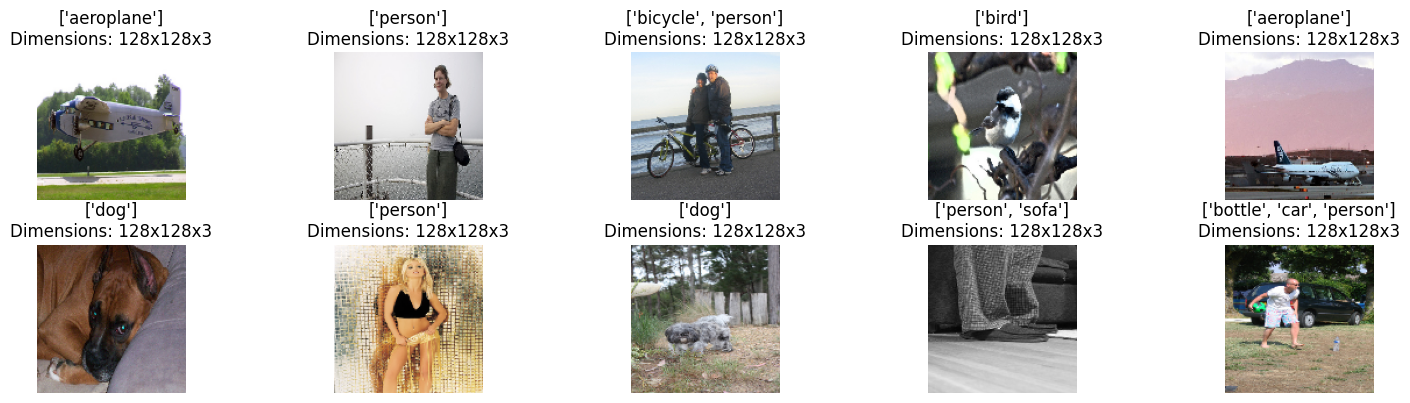

In [21]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(train_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in train_labels[random_indices]]
images = [i for i in train_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

### Validation set

In [22]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [23]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [24]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [25]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 128, 128, 3)

In [26]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.21130387485027313 GB


Labels encoding:

In [27]:
validation_labels = validation_data['labels']
validation_labels.shape

(1154,)

In [28]:
encoded_validation_labels = np.array([vector_encoding(l, N_CLASSES) for l in validation_labels])
encoded_validation_labels.shape, encoded_validation_labels[0], validation_labels[0]

((1154, 20),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 ['boat'])

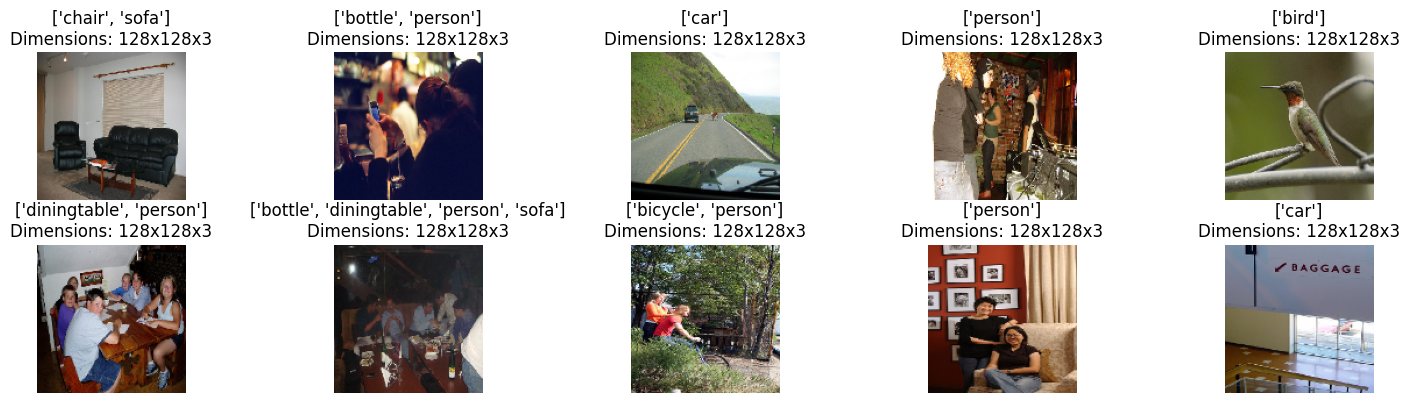

In [29]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(validation_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in validation_labels[random_indices]]
images = [i for i in validation_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

### Test set

In [30]:
test_data = np.load(TEST_PATH, allow_pickle=True)
test_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/test.npz' with keys: images, labels

In [31]:
test_images = test_data['images']
test_images.shape

(1154, 227, 227, 3)

In [32]:
print(f'Size of test images before preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [33]:
test_images = preprocess_images(test_images)
test_images.shape

(1154, 128, 128, 3)

In [34]:
print(f'Size of test images after preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images after preprocessing: 0.21130387485027313 GB


Labels encoding:

In [35]:
test_labels = test_data['labels']
test_labels.shape

(1154,)

In [36]:
encoded_test_labels = np.array([vector_encoding(l, N_CLASSES) for l in test_labels])
encoded_test_labels.shape, encoded_test_labels[0], test_labels[0]

((1154, 20),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 ['bottle', 'person', 'tvmonitor'])

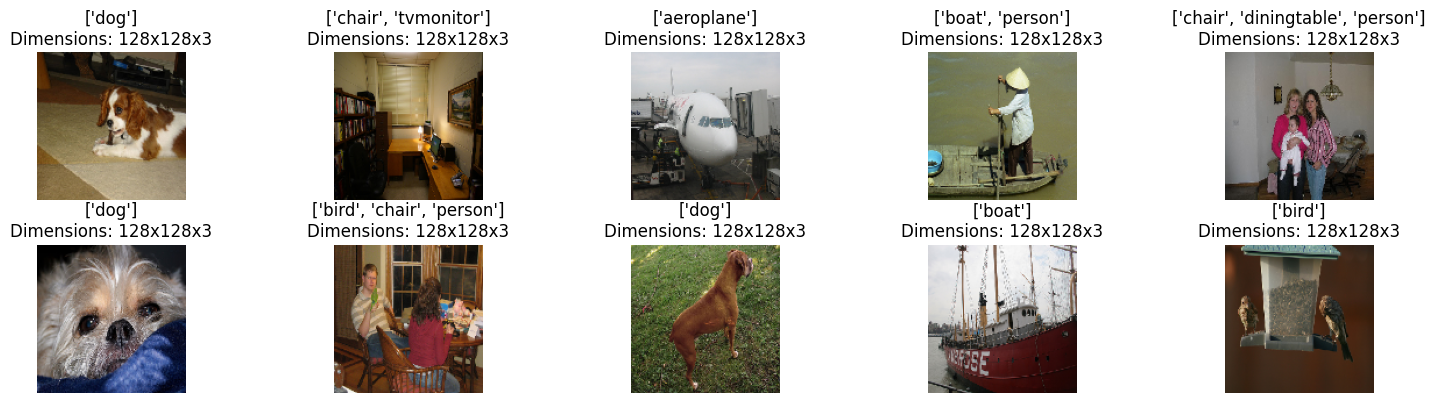

In [37]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(test_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in test_labels[random_indices]]
images = [i for i in test_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## Models

### Base model

In [38]:
def create_base_model(input_shape=(128, 128, 3), num_classes=N_CLASSES, dropout_rate=0.3, model_name="baseline_model", model_path=None):
    if model_path is not None:
        return tf.keras.models.load_model(f"{MODELS_DIR}{model_name}.keras")

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_initializer="HeNormal"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ], name=model_name)

    # Precision
    precision = tf.keras.metrics.Precision(
        thresholds=0.5,
        name='precision',
    )

    # Recall
    recall = tf.keras.metrics.Recall(
        thresholds=0.5,
        name='recall',
    )

    # F1-score
    f1_score = tf.keras.metrics.F1Score(
        average='weighted',
        threshold=0.5,
        name='f1_score'
    )

    # Mean Average Precision (mAP)
    map_metric = tf.keras.metrics.AUC(
        curve='PR',  # Precision-Recall curve
        multi_label=True,
        name='mAP'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            perfect_accuracy,
            map_metric,
            precision,
            recall,
            f1_score
        ]
    )

    return model

In [39]:
base_model_name = 'baseline_model'
base_model = create_base_model(input_shape=(128, 128, 3), model_name=base_model_name, model_path=f'{MODELS_DIR}{base_model_name}.keras')
base_model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 58, 58, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,011,198 (3.86 MB)

 Trainable params: 336,788 (1.28 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 673,578 (2.57 MB)

In [40]:
print(f'Size of model: {asizeof.asizeof(base_model) / (1024**2)} MB')

Size of model: 2.6883697509765625 MB


#### Training

In [41]:
BATCH_SIZE = 64

In [42]:
early_stopping = EarlyStopping(monitor='val_f1_score', patience=30, restore_best_weights=True)
early_stopping

In [ ]:
history = base_model.fit(
    train_images,
    encoded_train_labels,
    validation_data=(validation_images, encoded_validation_labels),
    batch_size=BATCH_SIZE,
    epochs=500,
    callbacks=[early_stopping],
)

Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - f1_score: 0.2747 - loss: 0.1723 - mAP: 0.3480 - perfect_accuracy: 0.1175 - precision: 0.7249 - recall: 0.2057 - val_f1_score: 0.1422 - val_loss: 0.2295 - val_mAP: 0.2167 - val_perfect_accuracy: 0.0444 - val_precision: 0.6978 - val_recall: 0.0953
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - f1_score: 0.2718 - loss: 0.1716 - mAP: 0.3527 - perfect_accuracy: 0.1160 - precision: 0.7247 - recall: 0.2040 - val_f1_score: 0.1199 - val_loss: 0.2465 - val_mAP: 0.2095 - val_perfect_accuracy: 0.0362 - val_precision: 0.6276 - val_recall: 0.0746
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - f1_score: 0.2782 - loss: 0.1711 - mAP: 0.3548 - perfect_accuracy: 0.1168 - precision: 0.7132 - recall: 0.2102 - val_f1_score: 0.1188 - val_loss: 0.2301 - val_mAP: 0.2172 - val_perfect_accuracy: 0.0362 - val_precision: 0.6289 - val_recall: 0.0740
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - f1_score: 0.2806 - loss: 0.1704 - mA

In [ ]:
plot_history(history)

#### Validation

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step


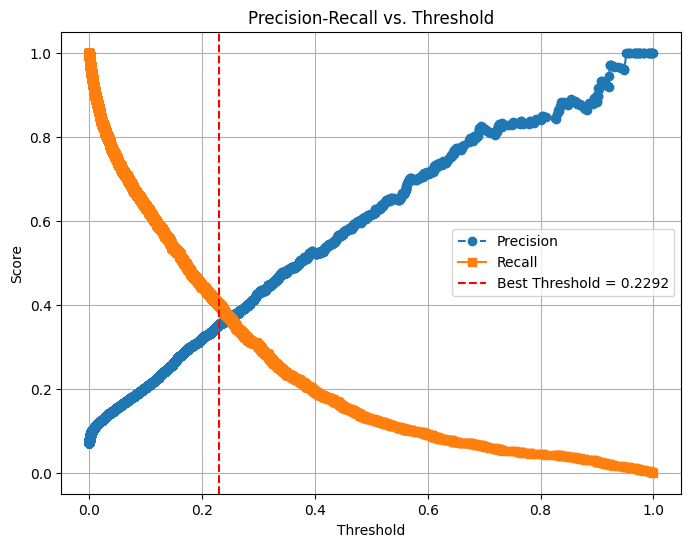

0.22919646

In [43]:
y_pred_probs = base_model.predict(validation_images)

precisions, recalls, thresholds = precision_recall_curve(
    encoded_validation_labels.flatten(), y_pred_probs.flatten()
)

best_threshold = thresholds[np.argmax(precisions * recalls / (precisions + recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--', marker='o')
plt.plot(thresholds, recalls[:-1], label="Recall", linestyle='-', marker='s')

plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

best_threshold

#### Test

In [44]:
y_pred = base_model.predict(test_images)
y_pred[0]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([4.2729294e-05, 4.2225472e-03, 5.3581372e-03, 7.8870810e-04,
       1.5851842e-01, 1.7218988e-05, 3.9144554e-03, 5.6996461e-02,
       4.2596850e-01, 6.9694693e-04, 1.9751447e-01, 5.3013243e-02,
       1.3272966e-03, 7.6446733e-05, 3.2300657e-01, 1.3372295e-01,
       6.6257239e-04, 1.5745582e-01, 2.1496620e-04, 1.8763131e-01],
      dtype=float32)

In [45]:
y_pred_binary = (y_pred > best_threshold).astype(int)
y_pred_binary[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

##### Accuracy

In [46]:
perfect_acc = perfect_accuracy(encoded_test_labels, y_pred_binary)
perfect_acc.numpy()

0.06499133

##### Binary accuracy

In [47]:
accuracy = tf.keras.metrics.BinaryAccuracy()
accuracy.update_state(encoded_test_labels, y_pred_binary)
accuracy.result().numpy()

0.9016898

##### Mean Average Precision (mAP)

In [48]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.261666

##### Precision

In [49]:
precision = tf.keras.metrics.Precision(
    name='precision',
)

precision.update_state(encoded_test_labels, y_pred_binary)
precision.result().numpy()

0.34379905

##### Recall

In [50]:
recall = tf.keras.metrics.Recall(
    name='recall',
)

recall.update_state(encoded_test_labels, y_pred_binary)
recall.result().numpy()

0.39294258

##### F1-score

In [51]:
f1 = tf.keras.metrics.F1Score(
    name='f1_score',
    average='weighted'
)

f1.update_state(encoded_test_labels, y_pred_binary)
f1.result().numpy()

0.293557

In [52]:
base_model_metrics = {
    'perfect_accuracy': perfect_acc.numpy(),
    'binary_accuracy': accuracy.result().numpy(),
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1.result().numpy(),
    'map_metric': map_metric.result().numpy(),
}

base_model_metrics

{'perfect_accuracy': 0.06499133,
 'binary_accuracy': 0.9016898,
 'precision': 0.34379905,
 'recall': 0.39294258,
 'f1_score': 0.293557,
 'map_metric': 0.261666}

In [53]:
base_model.save(f"{MODELS_DIR}{base_model.name}.keras")

### Data augmented model

In [54]:
train_datagen = ImageDataGenerator(
    rotation_range=25,           # Rotazione casuale fino a ±25 gradi
    width_shift_range=0.2,       # Traslazione orizzontale fino al 20% della larghezza
    height_shift_range=0.2,      # Traslazione verticale fino al 20% dell'altezza
    shear_range=0.25,            # Trasformazione prospettica (shear) fino al 25%
    zoom_range=[0.7, 1.2],       # Zoom casuale tra il 70% e il 120%
    channel_shift_range = 0.3,   # Variazione di intensità dei colori fino al 30%
    preprocessing_function=lambda x: np.fliplr(x) if np.random.random() < 0.3 else x,   # Flip orizzontale con probabilità del 30%
    fill_mode='reflect',          # Riempimento dei pixel mancanti tramite riflessione dei pixel più vicini
)

train_datagen.fit(train_images)

BATCH_SIZE = 64

train_generator = train_datagen.flow(
    train_images,
    encoded_train_labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_STATE
)
train_generator

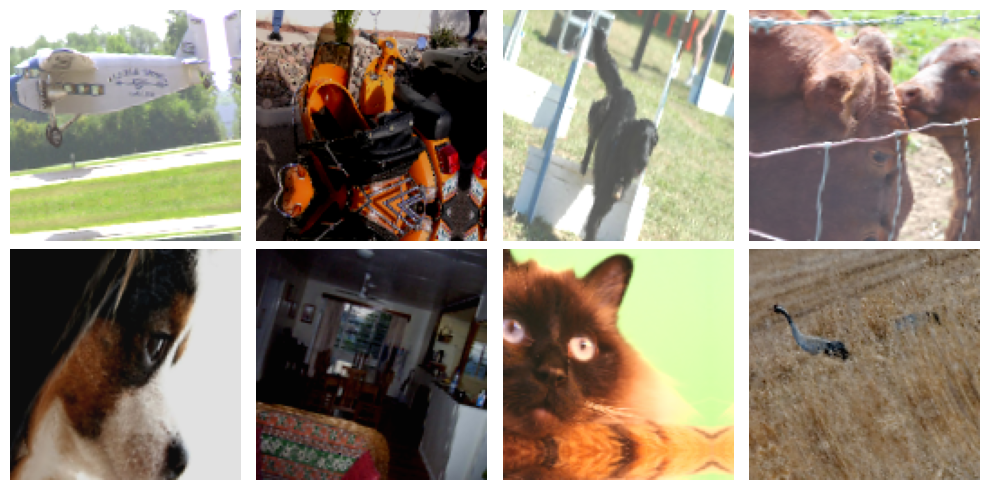

In [55]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    for x, y in train_generator:
        plt.imshow(x[0])
        plt.axis('off')
        break

plt.tight_layout()
plt.show()

In [56]:
base_augmented_model_name = 'baseline_augmented_model'
base_augmented_model = create_base_model(input_shape=(128, 128, 3), model_name=base_augmented_model_name, model_path=f'{MODELS_DIR}{base_augmented_model_name}.keras')
base_augmented_model.summary()

Model: "baseline_augmented_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_61 (Dropout)                 │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 58, 58, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,011,198 (3.86 MB)

 Trainable params: 336,788 (1.28 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 673,578 (2.57 MB)

#### Training

In [57]:
early_stopping = EarlyStopping(monitor='val_f1_score', patience=30, restore_best_weights=True)
early_stopping

In [58]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_augmented_model_epoch_{epoch:02d}.keras',
    monitor='val_f1_score',
    mode='max',
    save_freq='epoch',
    save_best_only=True
    )

In [ ]:
history = base_augmented_model.fit(
    train_generator,
    validation_data=(validation_images, encoded_validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 81s 436ms/step - f1_score: 0.3159 - loss: 0.1825 - mAP: 0.3220 - perfect_accuracy: 0.1207 - precision: 0.7243 - recall: 0.1828 - val_f1_score: 0.2861 - val_loss: 0.1872 - val_mAP: 0.3152 - val_perfect_accuracy: 0.0465 - val_precision: 0.7892 - val_recall: 0.1068
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - f1_score: 0.3145 - loss: 0.1835 - mAP: 0.3166 - perfect_accuracy: 0.1129 - precision: 0.7239 - recall: 0.1798 - val_f1_score: 0.2786 - val_loss: 0.1900 - val_mAP: 0.3042 - val_perfect_accuracy: 0.0414 - val_precision: 0.8136 - val_recall: 0.0874
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - f1_score: 0.3166 - loss: 0.1826 - mAP: 0.3230 - perfect_accuracy: 0.1160 - precision: 0.7314 - recall: 0.1810 - val_f1_score: 0.2570 - val_loss: 0.1937 - val_mAP: 0.2907 - val_perfect_accuracy: 0.0422 - val_precision: 0.8252 - val_recall: 0.1032
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - f1_score: 0.3272 - loss: 0.181

In [ ]:
plot_history(history)

#### Validation

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


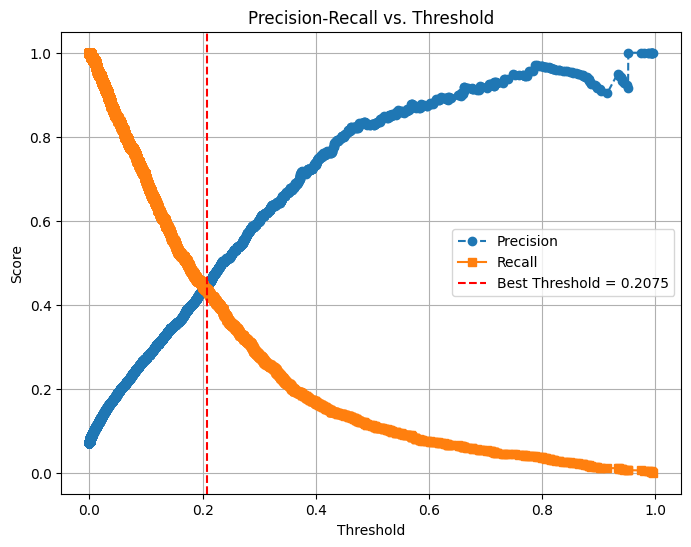

0.20747127

In [59]:
y_pred_probs = base_augmented_model.predict(validation_images)

precisions, recalls, thresholds = precision_recall_curve(
    encoded_validation_labels.flatten(), y_pred_probs.flatten()
)

best_threshold = thresholds[np.argmax(precisions * recalls / (precisions + recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--', marker='o')
plt.plot(thresholds, recalls[:-1], label="Recall", linestyle='-', marker='s')

plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

best_threshold

#### Test

In [60]:
y_pred = base_augmented_model.predict(test_images)
y_pred[0]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([0.00392837, 0.0191133 , 0.02872728, 0.0099861 , 0.13669635,
       0.0016066 , 0.02481665, 0.0547144 , 0.2758987 , 0.00475787,
       0.16058986, 0.07709549, 0.01253318, 0.00585535, 0.48380524,
       0.11195248, 0.00348188, 0.11630692, 0.00395345, 0.11970789],
      dtype=float32)

In [61]:
y_pred_binary = (y_pred > best_threshold).astype(int)
y_pred_binary[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

##### Accuracy

In [62]:
perfect_acc = perfect_accuracy(encoded_test_labels, y_pred_binary)
perfect_acc.numpy()

0.1135182

##### Binary accuracy

In [63]:
accuracy = tf.keras.metrics.BinaryAccuracy()
accuracy.update_state(encoded_test_labels, y_pred_binary)
accuracy.result().numpy()

0.91884756

##### Mean Average Precision (mAP)

In [64]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.3582096

##### Precision

In [65]:
precision = tf.keras.metrics.Precision(
    name='precision',
)

precision.update_state(encoded_test_labels, y_pred_binary)
precision.result().numpy()

0.43586472

##### Recall

In [66]:
recall = tf.keras.metrics.Recall(
    name='recall',
)

recall.update_state(encoded_test_labels, y_pred_binary)
recall.result().numpy()

0.40849283

##### F1-score

In [67]:
f1 = tf.keras.metrics.F1Score(
    name='f1_score',
    average='weighted'
)

f1.update_state(encoded_test_labels, y_pred_binary)
f1.result().numpy()

0.3750974

In [68]:
base_augmented_model_metrics = {
    'perfect_accuracy': perfect_acc.numpy(),
    'binary_accuracy': accuracy.result().numpy(),
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1.result().numpy(),
    'map_metric': map_metric.result().numpy(),
}

base_augmented_model_metrics

{'perfect_accuracy': 0.1135182,
 'binary_accuracy': 0.91884756,
 'precision': 0.43586472,
 'recall': 0.40849283,
 'f1_score': 0.3750974,
 'map_metric': 0.3582096}

In [69]:
base_augmented_model.save(f"{MODELS_DIR}{base_augmented_model.name}.keras")

## Models comparison

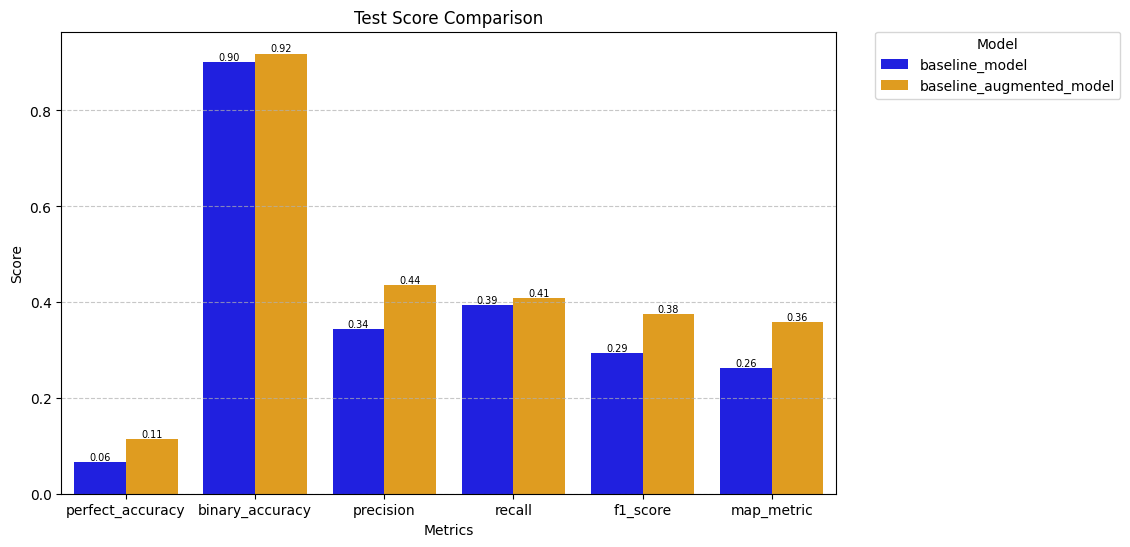

In [70]:
scores = {
    'name': [base_model.name, base_augmented_model.name],
    'perfect_accuracy': [base_model_metrics['perfect_accuracy'], base_augmented_model_metrics['perfect_accuracy']],
    'binary_accuracy': [base_model_metrics['binary_accuracy'], base_augmented_model_metrics['binary_accuracy']],
    'precision': [base_model_metrics['precision'], base_augmented_model_metrics['precision']],
    'recall': [base_model_metrics['recall'], base_augmented_model_metrics['recall']],
    'f1_score': [base_model_metrics['f1_score'], base_augmented_model_metrics['f1_score']],
    'map_metric': [base_model_metrics['map_metric'], base_augmented_model_metrics['map_metric']],
}

df = pd.DataFrame(scores)
df_melted = df.melt(id_vars="name", var_name="metric", value_name="score")

palette = {
    base_model.name: 'blue',
    base_augmented_model.name: 'orange'
}

# Creazione del grafico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="metric", y="score", hue="name", data=df_melted, palette=palette)

for p in ax.patches:
  if p.get_height() > 0:  # Evita di stampare etichette per barre di altezza zero
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color="black")

# Migliorare la leggibilità
plt.title("Test Score Comparison")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()